In [50]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import numpy as np
from matplotlib import pyplot as plt 

In [51]:
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')


In [64]:
# def to_img(x):
#     x = 0.5 * (x + 1)
#     x = x.clamp(0, 1)
#     x = x.view(x.size(0), 1, 28, 28)
#     return x


def to_img(y):
    y = 0.5 * (y + 1)
    y = y.view(y.size(0), 28, 28)
    return y

In [65]:
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [66]:
num_epochs = 10
batch_size = 256
learning_rate = 1e-3

In [67]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])


In [68]:
dataset = MNIST('./data', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [72]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [74]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

epoch [1/10], loss:0.1246
epoch [2/10], loss:0.2434
epoch [3/10], loss:0.3657
epoch [4/10], loss:0.4847
epoch [5/10], loss:0.5978
epoch [6/10], loss:0.7099
epoch [7/10], loss:0.8199
epoch [8/10], loss:0.9282
epoch [9/10], loss:1.0413
epoch [10/10], loss:1.1457


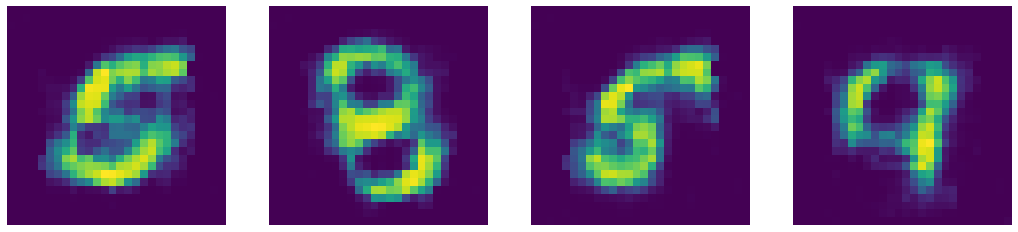

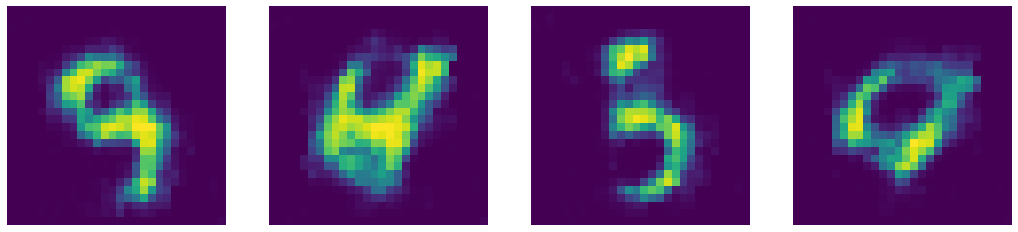

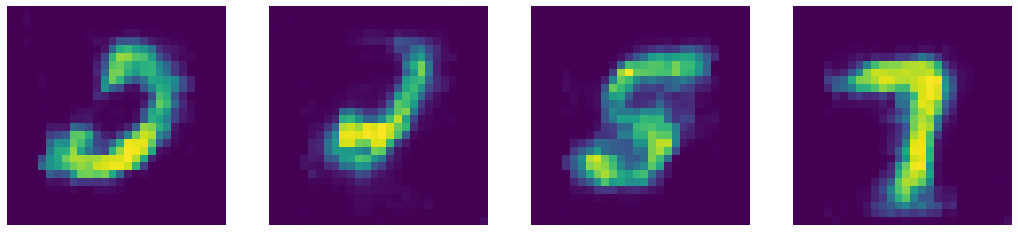

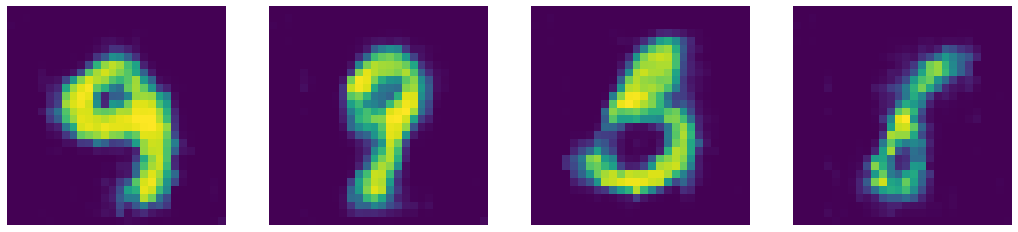

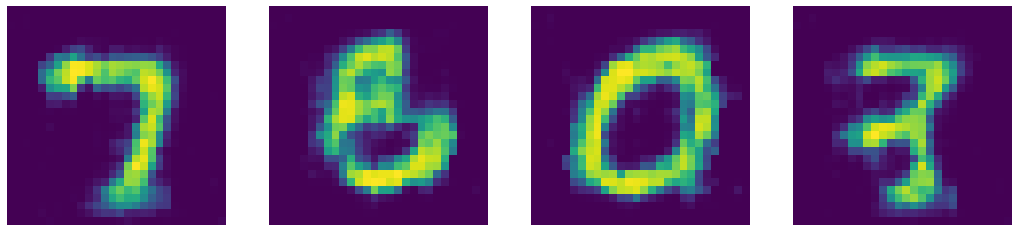

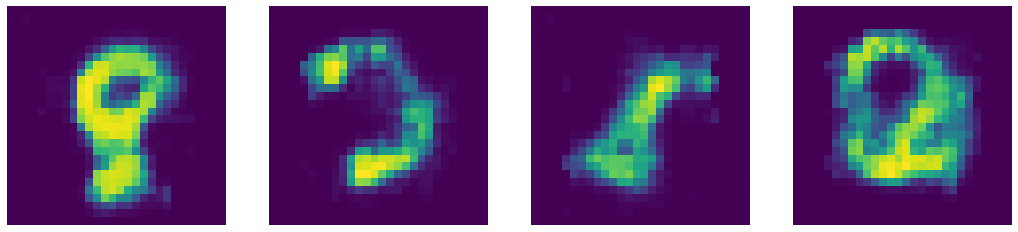

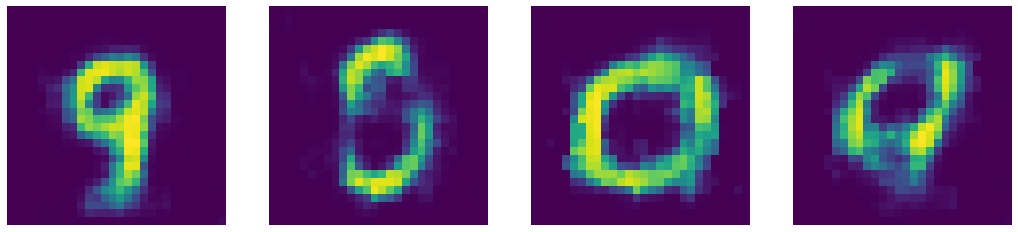

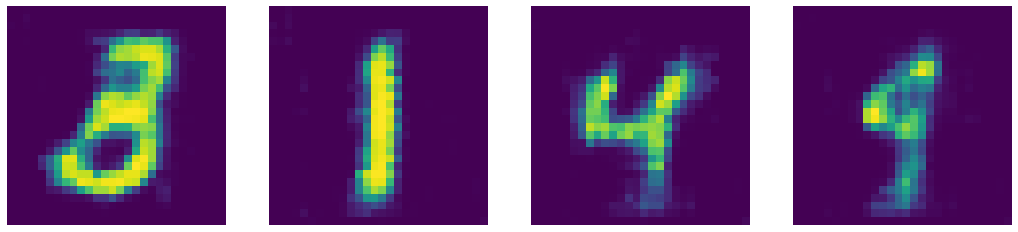

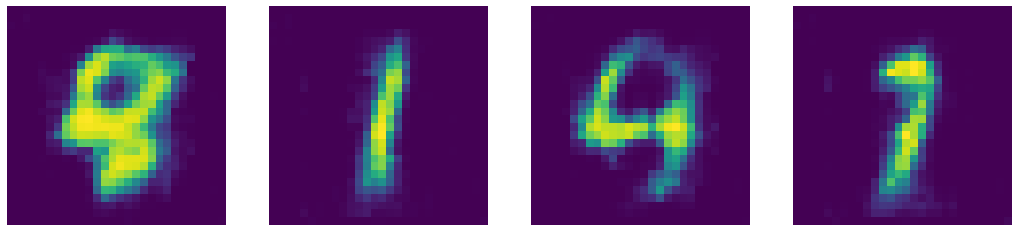

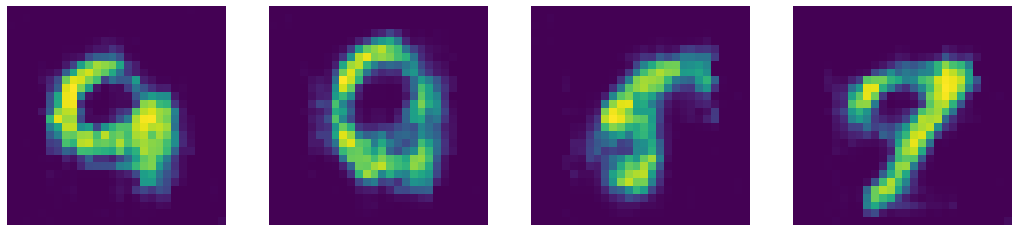

In [76]:
total_loss = 0
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    total_loss += loss.data
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))
    if epoch % 10 == 0:
        
        display_images(None, output, 10)
#         pic = to_img(output.cpu().data)
#         save_image(pic, './dc_img/image_{}.png'.format(epoch))


In [ ]:
torch.save(model.state_dict(), './conv_autoencoder.pth')